# Logistic regression theory vs empirical simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio
import matplotlib.patches

import typing
import os
import shutil
import sys

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPERIMENT_NAME = 'logistic_regression_theory_empirical'

EXPORT_NAME = EXPERIMENT_NAME

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE = (2.6, 1.4)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT
LEGEND_FIGURE_SIZE = (2.6, 0.55)

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPORT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
def load_runs(experiment_name: str) -> pd.DataFrame:
    client = mlflow.tracking.MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    all_runs = mlflow.search_runs(
        experiment.experiment_id
    )
    all_runs = all_runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

    # Convert some parameters to numbers and sort accordingly
    all_runs['params.data_dim'] = all_runs['params.data_dim'].astype(int)
    all_runs['params.train_attack_epsilon'] = all_runs['params.train_attack_epsilon'].astype(np.float)
    all_runs['params.test_attack_epsilon'] = all_runs['params.test_attack_epsilon'].astype(np.float)
    all_runs['params.l2_lambda'] = all_runs['params.l2_lambda'].astype(np.float)
    
    all_runs = all_runs.sort_values(['params.data_dim', 'params.l2_lambda'], ascending=False)
    print('Loaded', len(all_runs), 'runs of experiment', experiment_name)
    assert all_runs['status'].eq('FINISHED').all()
    return all_runs

overparam_runs = load_runs(EXPERIMENT_NAME)

Loaded 64 runs of experiment logistic_regression_theory_empirical


## Plots

In [8]:
std_risk_color_idx = 0
robust_risk_color_idx = 1

data_dims = overparam_runs['params.data_dim'].unique()
num_samples, = overparam_runs['params.data_num_train_samples'].astype(int).unique()
assert overparam_runs['params.train_consistent_attacks'].eq('True').all()

l2_lambdas_ls = {
    0.0: ('-', 'D'),
    1.0: ('--', 'x')
}

lambda_label_map = {
    0.0: r'$\lambda \to 0$',
    1.0: r'$\lambda = 1$'
}

epsilon = 0.05

SCATTER_LEGEND = False


In [9]:
theory_predictions = dict()
theory_gammas = dict()
for l2_lambda in l2_lambdas_ls.keys():
    file_path = os.path.join(os.pardir, 'theory', f'theory_predictions_eps{epsilon:.2f}_lambda{l2_lambda:.5f}.csv')
    raw_predictions = pd.read_csv(file_path, sep=',', header=0).sort_values('gamma')
    theory_predictions[l2_lambda] = raw_predictions.apply(
        lambda row: ir.closed_form.logistic_regression_asymptotic_risks_linf(row['orth_l2_norm'], row['par_l2_norm'], row['proj_l1_norm'], epsilon),
        axis=1,
        result_type='expand'
    ).values
    theory_gammas[l2_lambda] = raw_predictions['gamma']


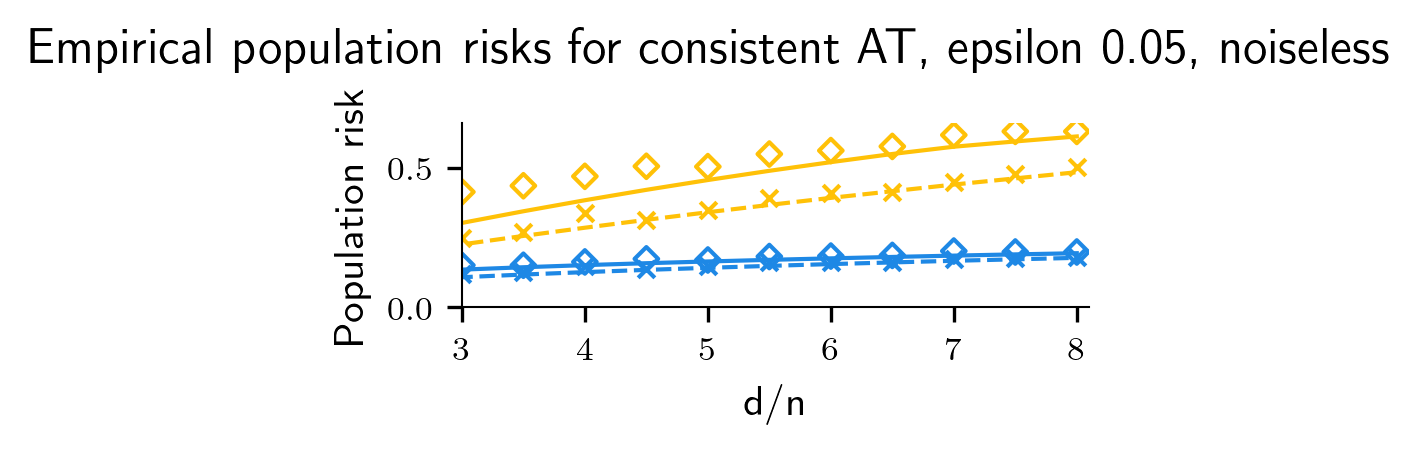

In [10]:
empirical_runs = overparam_runs[overparam_runs['params.test_attack_epsilon'] == epsilon]

fig, ax = plt.subplots(figsize=FIGURE_SIZE)

# Standard risk
for l2_lambda, (line_style, empirical_marker) in l2_lambdas_ls.items():
    # Theoretical predictions
    ax.plot(
        theory_gammas[l2_lambda],
        theory_predictions[l2_lambda][:, 0],
        label=fr'Std., {lambda_label_map[l2_lambda]}',
        c=f'C{std_risk_color_idx}',
        ls=line_style,
        zorder=1
    )

    # Empirical validation
    current_runs = empirical_runs[empirical_runs['params.l2_lambda'] == l2_lambda]
    ax.scatter(
        current_runs['params.data_dim'] / float(num_samples),
        current_runs['metrics.true_std_risk'],
        label=f'Std., {lambda_label_map[l2_lambda]}' if SCATTER_LEGEND else None,
        edgecolors=f'C{std_risk_color_idx}',
        facecolors='none' if empirical_marker != 'x' else None,
        marker=empirical_marker,
        zorder=2,
        **ir.plots.matplotlib_scatter_marker_settings()
    )

# Robust risk
for l2_lambda, (line_style, empirical_marker) in l2_lambdas_ls.items():
    # Theoretical predictions
    ax.plot(
        theory_gammas[l2_lambda],
        theory_predictions[l2_lambda][:, 1],
        label=fr'Robust, {lambda_label_map[l2_lambda]}',
        c=f'C{robust_risk_color_idx}',
        ls=line_style,
        zorder=1
    )

    # Empirical validation
    current_runs = empirical_runs[empirical_runs['params.l2_lambda'] == l2_lambda]
    ax.scatter(
        current_runs['params.data_dim'] / float(num_samples),
        current_runs['metrics.true_robust_risk'],
        label=f'Robust, {lambda_label_map[l2_lambda]}' if SCATTER_LEGEND else None,
        edgecolors=f'C{robust_risk_color_idx}',
        facecolors='none' if empirical_marker != 'x' else None,
        marker=empirical_marker,
        zorder=2,
        **ir.plots.matplotlib_scatter_marker_settings()
    )

ax.set_xlabel('d/n')
ax.set_ylabel('Population risk')
ax.set_ylim(bottom=0)
ax.set_xlim(3, 8.1)
ax.set_xticks(tuple(range(3, 8 + 1)))

overparam_handles, overparam_labels = ax.get_legend_handles_labels()

if SHOW_TITLES:
    fig.suptitle(f'Empirical population risks for consistent AT, epsilon {epsilon}, noiseless')

export_fig(fig, f'theory_vs_empirical.pdf')
plt.show()


In [11]:
# Legend
overparam_legend_fig = plt.figure(figsize=LEGEND_FIGURE_SIZE)
ir.plots.errorbar_legend(
    overparam_legend_fig,
    handles=overparam_handles,
    labels=overparam_labels,
    loc='center',
    ncol=2,
    mode='expand',
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.5
)

export_fig(overparam_legend_fig, f'theory_vs_empirical_legend.pdf')


<Figure size 780x165 with 0 Axes>